In [1]:
##INTRODUCTION
'''The objective of the study is to analyze the flight booking dataset obtained from 
“Ease My Trip” website and to conduct various statistical hypothesis tests in 
order to get meaningful information from it. The 'Linear Regression' statistical 
algorithm would be used to train the dataset and predict a continuous target variable. 
'Easemytrip' is an internet platform for booking flight tickets, and hence a platform 
that potential passengers use to buy tickets. A thorough study of the data will aid in 
the discovery of valuable insights that will be of enormous value to passengers.'''

##Research Questions
'''The aim of our study is to answer the below research questions:
a) Does price vary with Airlines?
b) How is the price affected when tickets are bought in just 1 or 2 days before departure?
c) Does ticket price change based on the departure time and arrival time?
d) How the price changes with change in Source and Destination?
e) How does the ticket price vary between Economy and Business class?'''

##References = https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction

'The aim of our study is to answer the below research questions:\na) Does price vary with Airlines?\nb) How is the price affected when tickets are bought in just 1 or 2 days before departure?\nc) Does ticket price change based on the departure time and arrival time?\nd) How the price changes with change in Source and Destination?\ne) How does the ticket price vary between Economy and Business class?'

In [2]:
import time
start = time.time()
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score,  mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import bartlett
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR

from logs_code import *
import pickle

In [3]:
logger = log(path="C:/Users/subodhkumar.n/Desktop/ML Practice/Flight-Price-Pridiction/Flight-prediction", file="flights_pred_logs.log")

In [4]:
# Reading what is in the Data
df=pd.read_csv('Clean_Dataset.csv')
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
# It is clear that Unnamed columns are not useful
# so dropping the useless column 'Unnamed: 0'
df=df.drop('Unnamed: 0',axis=1)

In [6]:
# A Quick Information about the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [7]:
#In this dataset we have around 300k rows. In order to reduce the runtime I want to take a sample portion
#There are different sampling methods like, random sampling, conditional sampling, sampling at constant rate.
#Here in this case I want to use a random sampling method.
#I want to take 60% data points from this population dataset. We can take sample by percentage or number(no. of rows).
sub_df = df.sample(frac=0.5)

In [8]:
# Statistical Description of Data
sub_df.describe()

,duration,days_left,price
count,150076.000000,150076.000000,150076.000000
mean,12.228640,26.022982,20950.858865
std,7.199114,13.556050,22756.230914
min,0.830000,1.000000,1105.000000
25%,6.750000,15.000000,4789.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,117307.000000


<AxesSubplot:xlabel='price'>

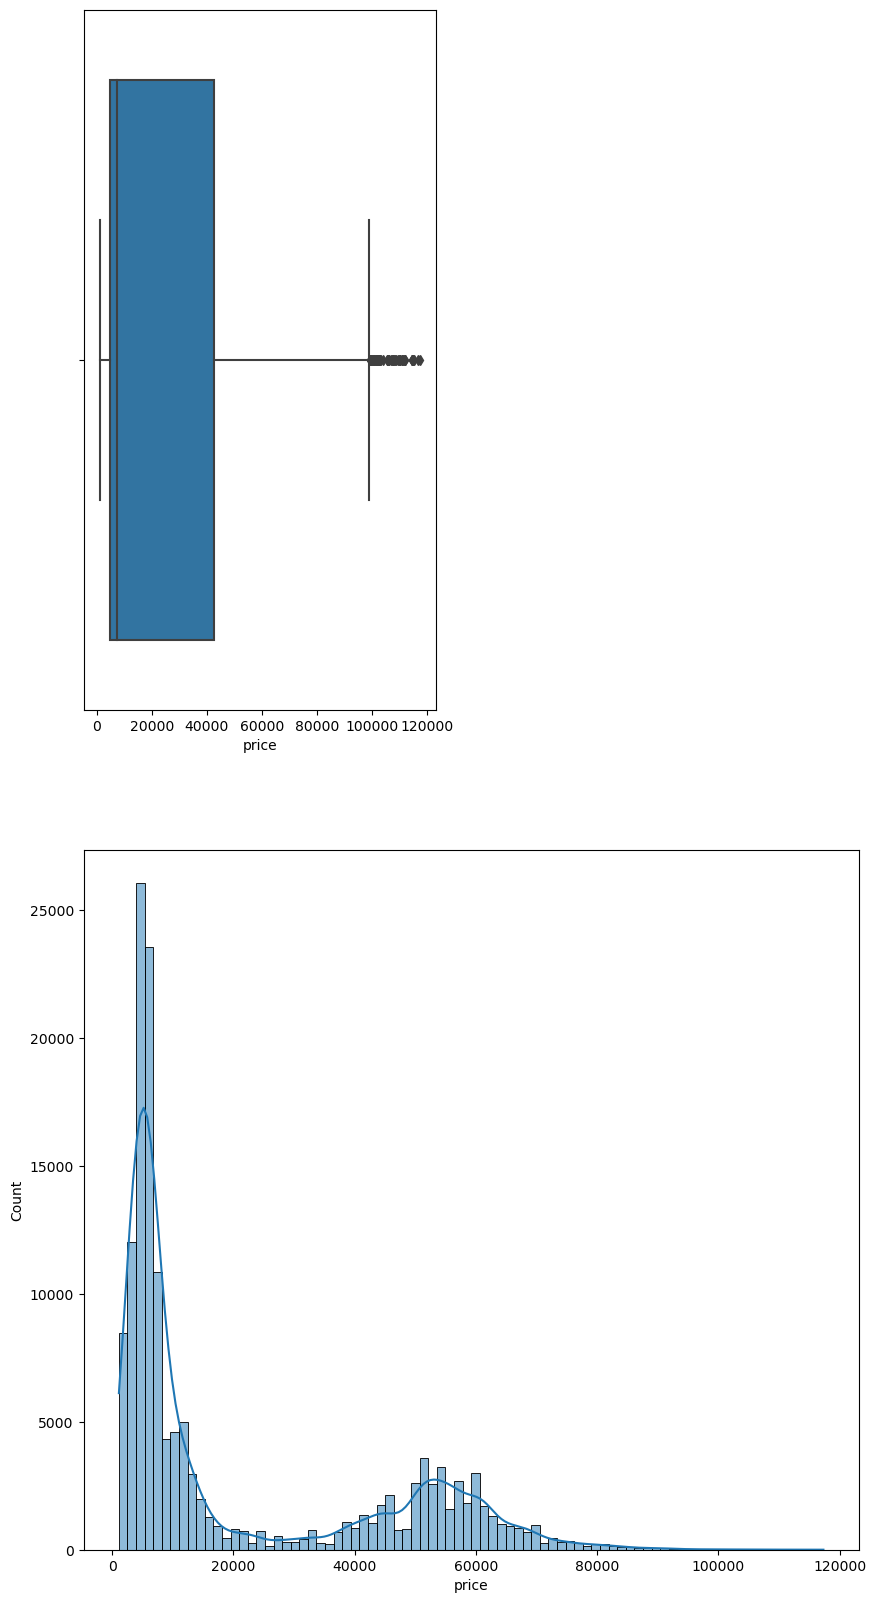

In [9]:
##Observations
#So now we have 150076 samples after taking 60% of population
#For both 'duration' and 'days_left' mean and median values are almost the same.
#But for 'price' there is big difference in  mean and median(50%) values.
plt.figure(figsize = (10,20))
plt.subplot(2,1,2)
sns.histplot(x = 'price', data = sub_df, kde = True)
plt.subplot(2,2,1)
sns.boxplot(x = 'price', data = sub_df)

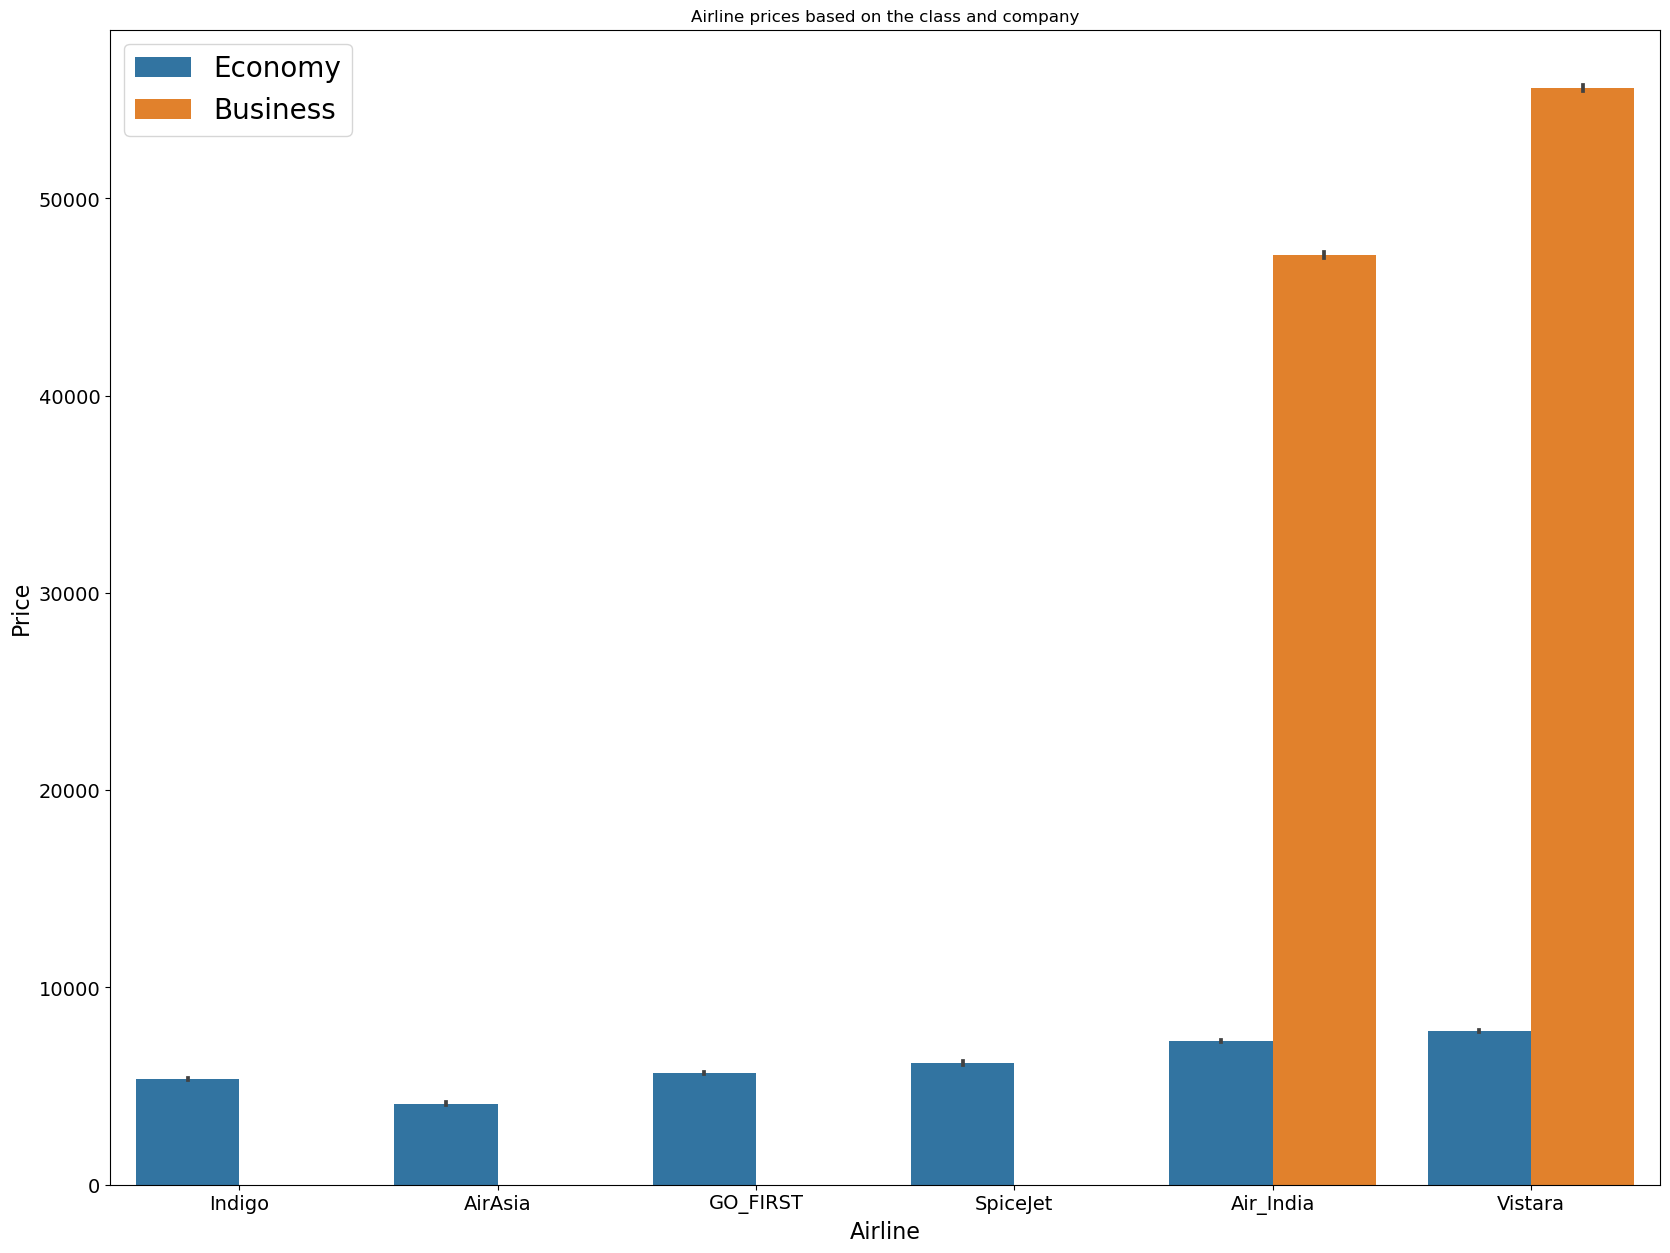

In [10]:
#Even though the mean is around 20000, we can see here that the median 
#is approximately 7500. This difference is explainable by the presence 
#of two different tickets: business and economy. On the second graph, we 
#can see that the dispersion seems to be composed by two gaussian curves.

##How does the ticket price vary between Economy and Business class?

plt.figure(figsize=(20, 15))
sns.barplot(x='airline',y='price',hue="class",data=sub_df.sort_values("price")).set_title('Airline prices based on the class and company')
plt.legend(loc='upper left', frameon=True, fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Airline', fontsize=16);
plt.ylabel('Price', fontsize=16);
plt.show()

In [11]:
#Business flights are only available in two companies: 
# Air India and Vistara. Also, there is a big gap between the 
# prices in the two class that reaches almost 5 times the price 
# of Economy for Business tickets.

##Checking for airlines that has more flights
sub_df1=sub_df.groupby(['flight','airline'],as_index=False).count()
sub_df1.airline.value_counts()

Indigo       697
Air_India    216
GO_FIRST     202
SpiceJet     180
Vistara      133
AirAsia      114
Name: airline, dtype: int64

In [12]:
# Indigo is the most popular airlines
sub_df2=sub_df.groupby(['flight','airline','class'],as_index=False).count()
sub_df2['class'].value_counts()

Economy     1540
Business     293
Name: class, dtype: int64

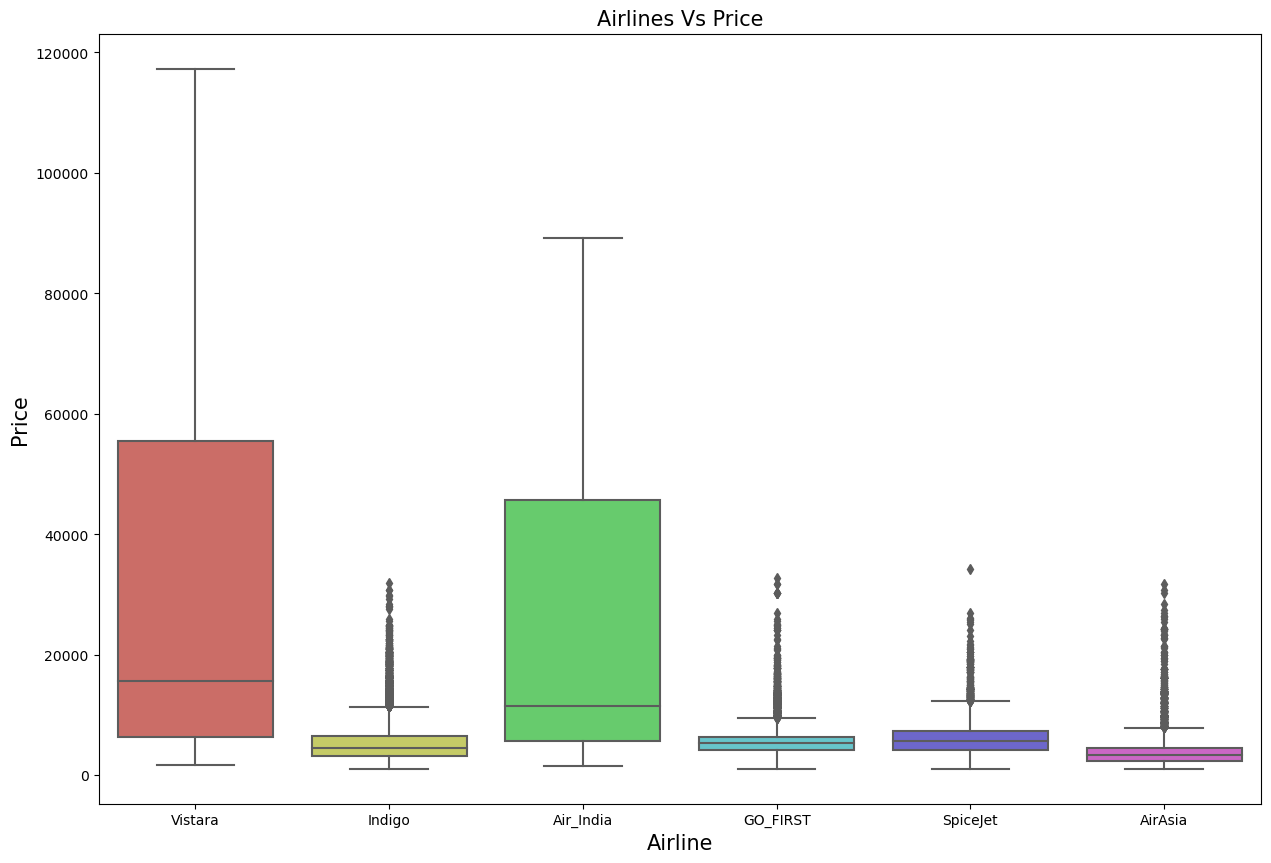

In [13]:
#Most of the Airlines has Economic Class as common.

##Does price vary with Airlines?
plt.figure(figsize=(15,10))
sns.boxplot(x=sub_df['airline'],y=sub_df['price'],palette='hls')
plt.title('Airlines Vs Price',fontsize=15)
plt.xlabel('Airline',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

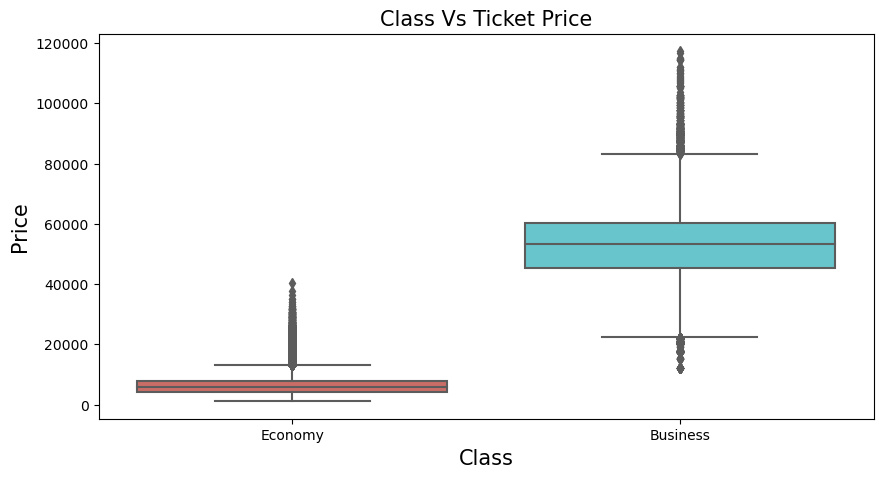

In [14]:
#There are slight differences between each companies on this graph, AirAsia 
# seems to have the cheapest flights when Air India and Vistara are more expensive.

##How Does the Ticket Price vary between Economy and Business Class?
plt.figure(figsize=(10,5))
sns.boxplot(x='class',y='price',data=sub_df,palette='hls')
plt.title('Class Vs Ticket Price',fontsize=15)
plt.xlabel('Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

Text(0.5, 1.0, 'Airline prices based on companies for business tickets')

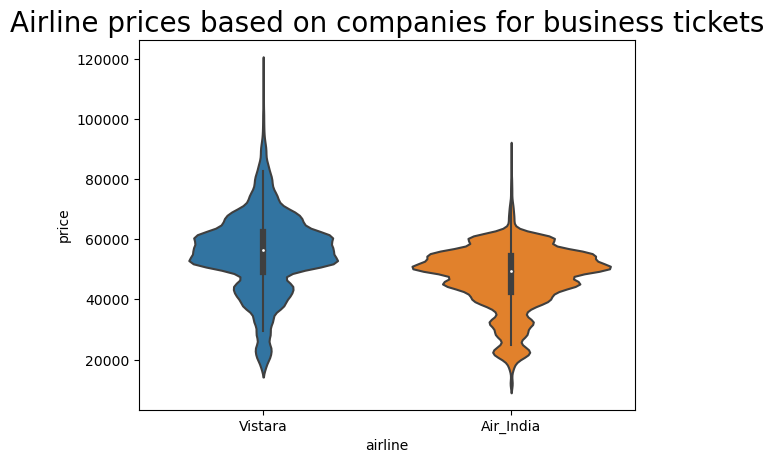

In [15]:
#There is a huge variation in the price of economy and business class tickets.
sns.violinplot(y = "price", x = "airline",data = sub_df.loc[df["class"]=='Business'].sort_values("price", ascending = False), kind="boxen")
plt.title("Airline prices based on companies for business tickets",fontsize=20)

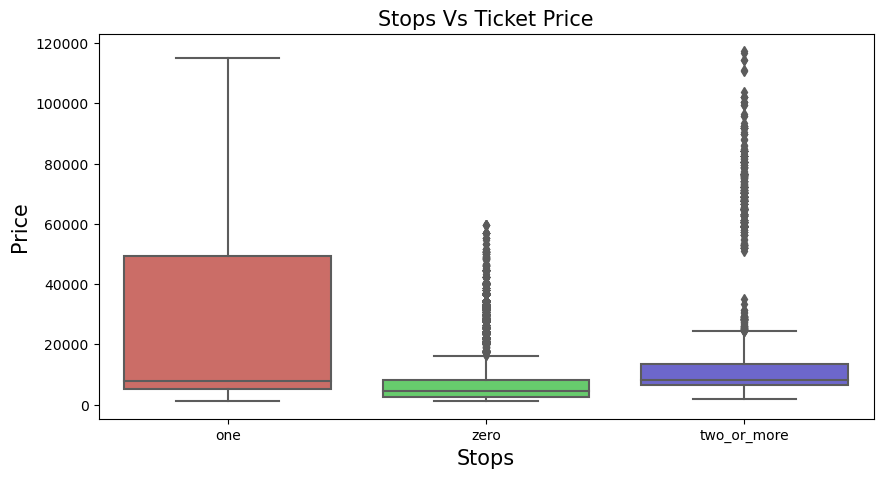

In [16]:
#It looks like Vistara's business tickets are a little more expensive than the Air India's ones.
#How does the Ticket Price vary with the number of stops of a Flight?
plt.figure(figsize=(10,5))
sns.boxplot(x='stops',y='price',data=sub_df,palette='hls')
plt.title('Stops Vs Ticket Price',fontsize=15)
plt.xlabel('Stops',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

Text(0.5, 1.0, 'Airline prices based on the number of stops  for economy')

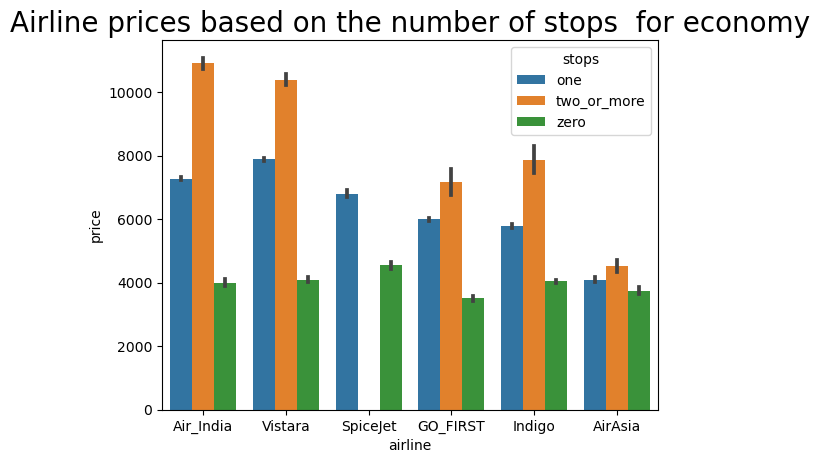

In [17]:
sns.barplot(y = "price", x = "airline",hue="stops",data = sub_df.loc[df["class"]=='Economy'].sort_values("price", ascending = False))
plt.title("Airline prices based on the number of stops  for economy",fontsize=20)

Text(0.5, 1.0, 'Airline prices based on the number of stops  for business')

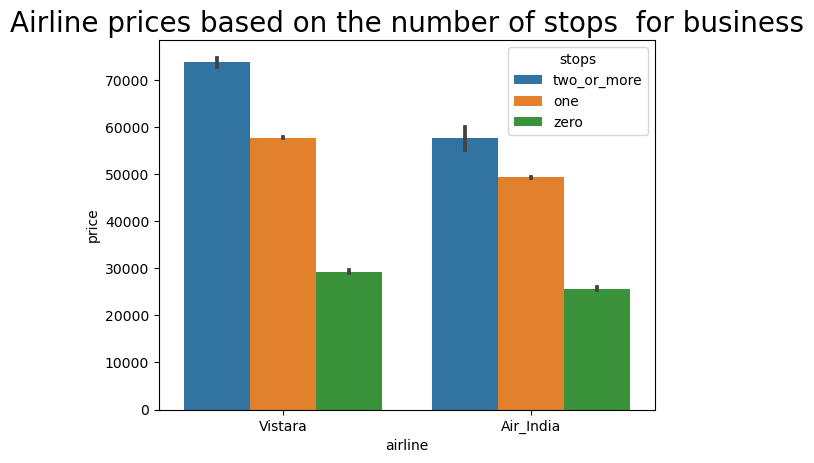

In [18]:
sns.barplot(y = "price", x = "airline",hue="stops",data = sub_df.loc[df["class"]=='Business'].sort_values("price", ascending = False))
plt.title("Airline prices based on the number of stops  for business",fontsize=20)

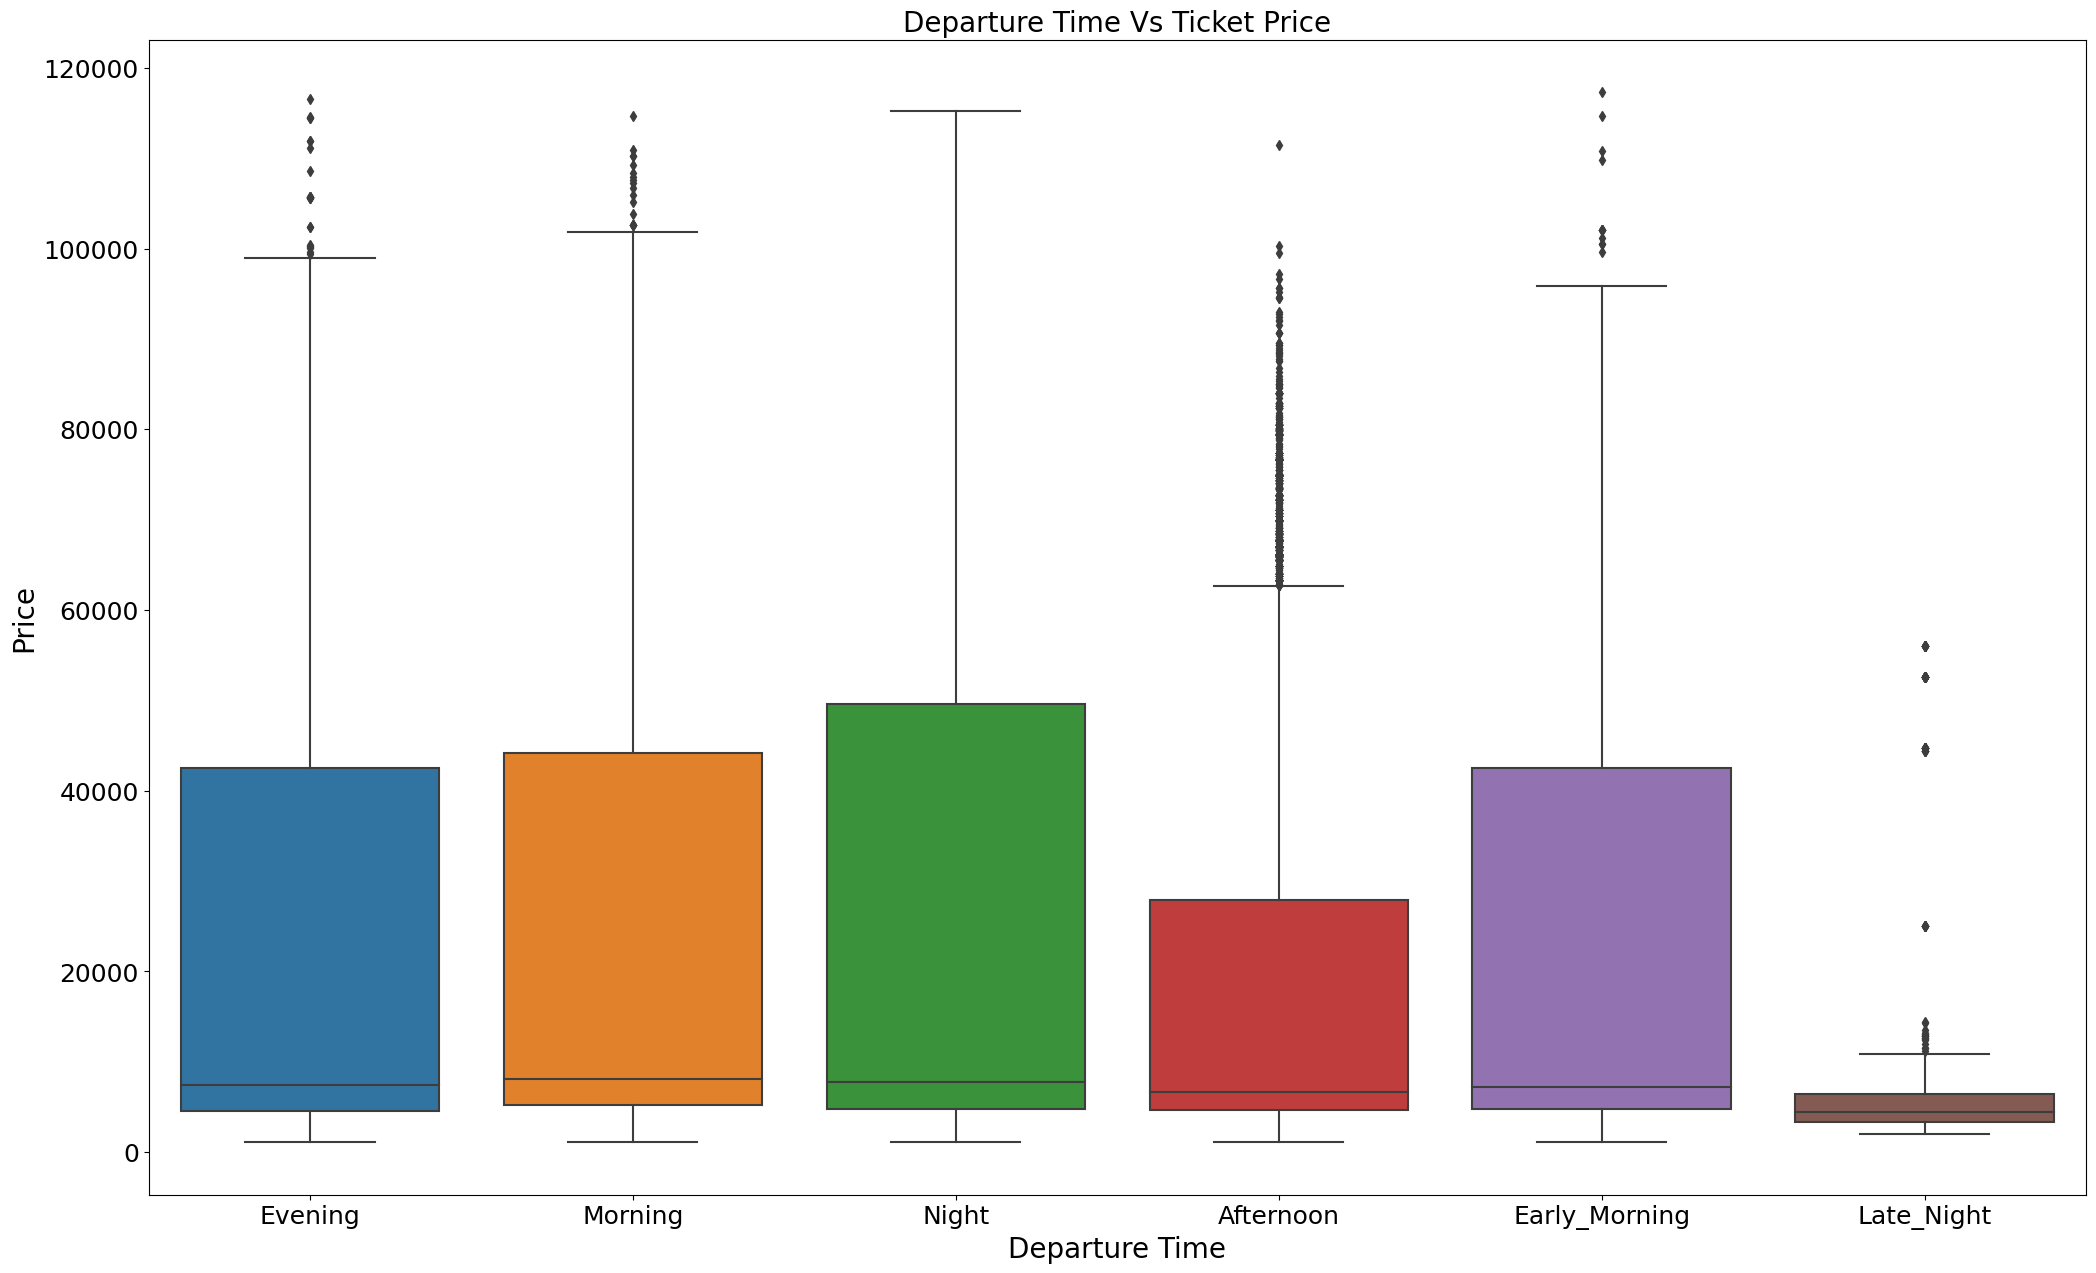

In [19]:
#It's clear that the more stops there are the more expensive the flight is 
#except for AirAsia where the prices seems more constant. The behaviour and 
#different analysis of AirAsia tend to show that it relates to a low cost company.

##How the Ticket Price change based on the Departure Time and Arrival Time?
#Checking based on the Departure Time.
plt.figure(figsize=(25,15))
sns.boxplot(x='departure_time',y='price',data=sub_df)
plt.title('Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

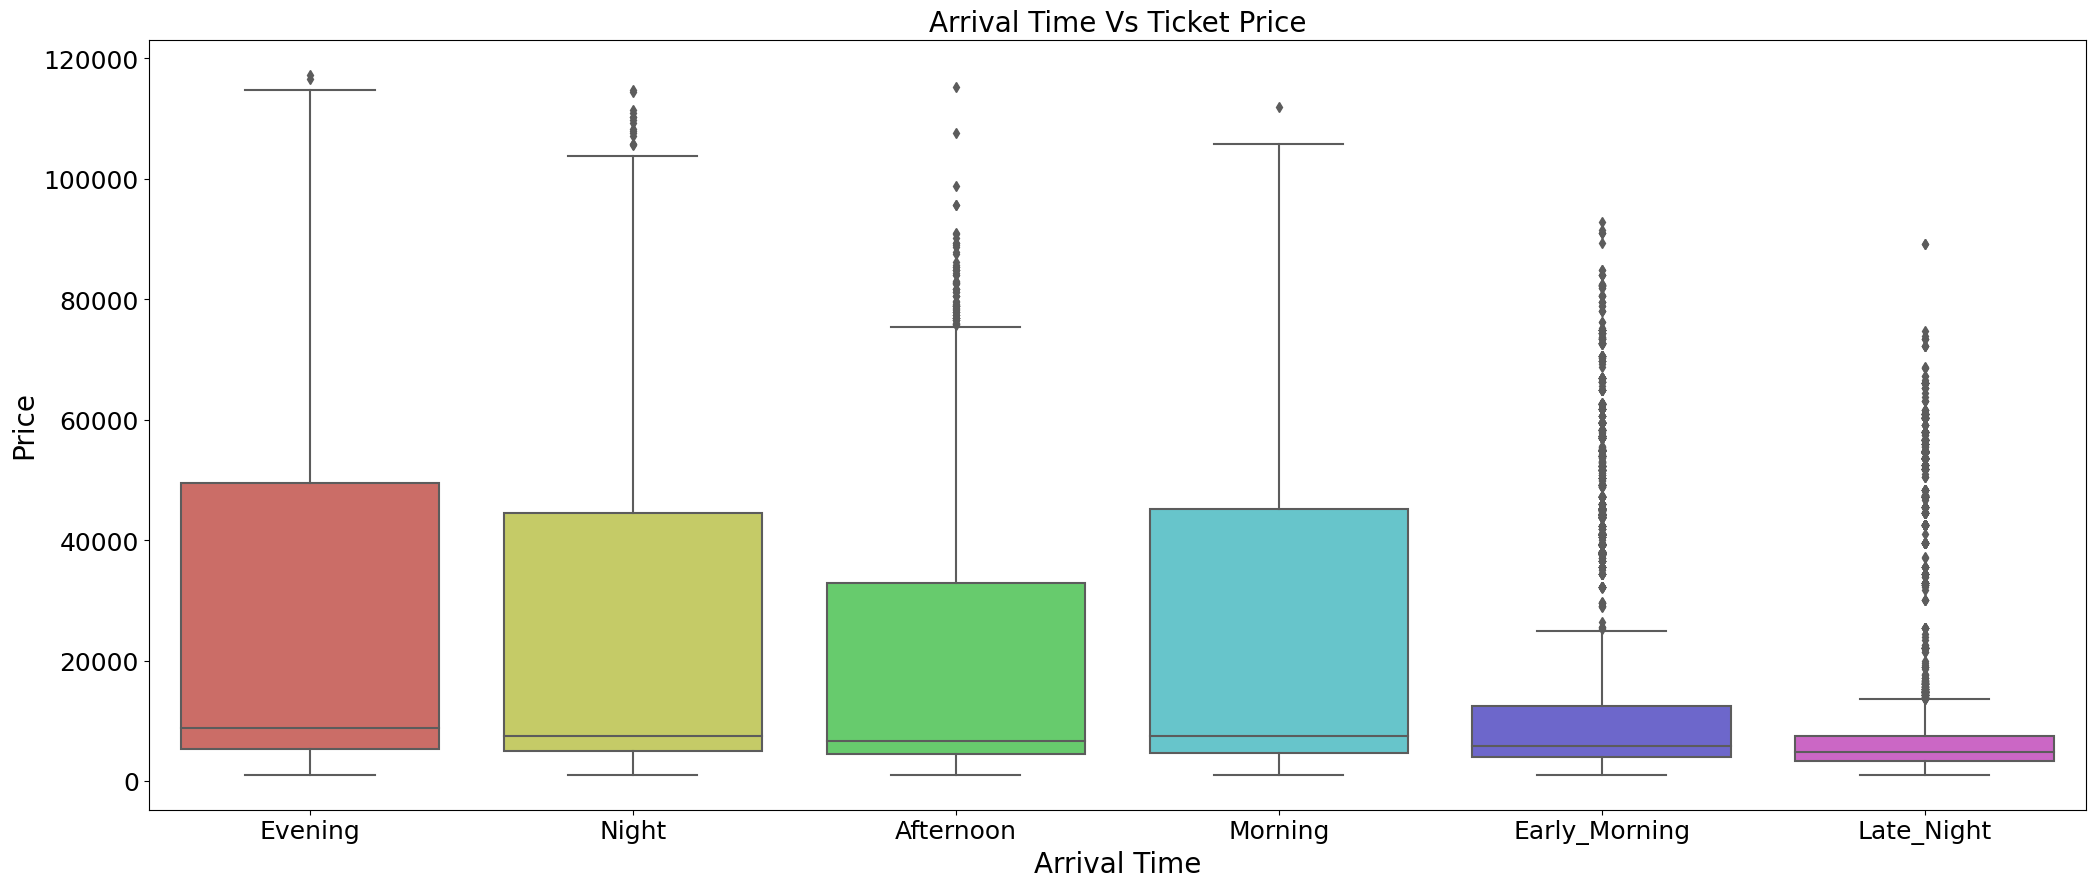

In [20]:
#Checking based on the arrival time.
plt.figure(figsize=(25,10))
sns.boxplot(x='arrival_time',y='price',data=sub_df,palette='hls')
plt.title('Arrival Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

In [21]:
##Observations
#Departure Time Vs Ticket Price
#Ticket Price is More for the Flights when the Departure Time is at Night
#Ticket Price is almost equal for flights Having Departure time at Early_morning , Morning and Evening
#Ticket Price is Low for the Flights Having Departure Time at Late_night

# Arrival Time Vs Ticket Price
#Ticket Price is More for the Flights when the Arrival Time is at Evening
#Ticket Price is almost equal for flights Having Arrival time is at Morning and Night
#Ticket Price is Low for the Flights Having Arrival Time at Late_night as same as Departure Time

Text(0.5, 0.98, 'Airline prices based on the source and destination cities')

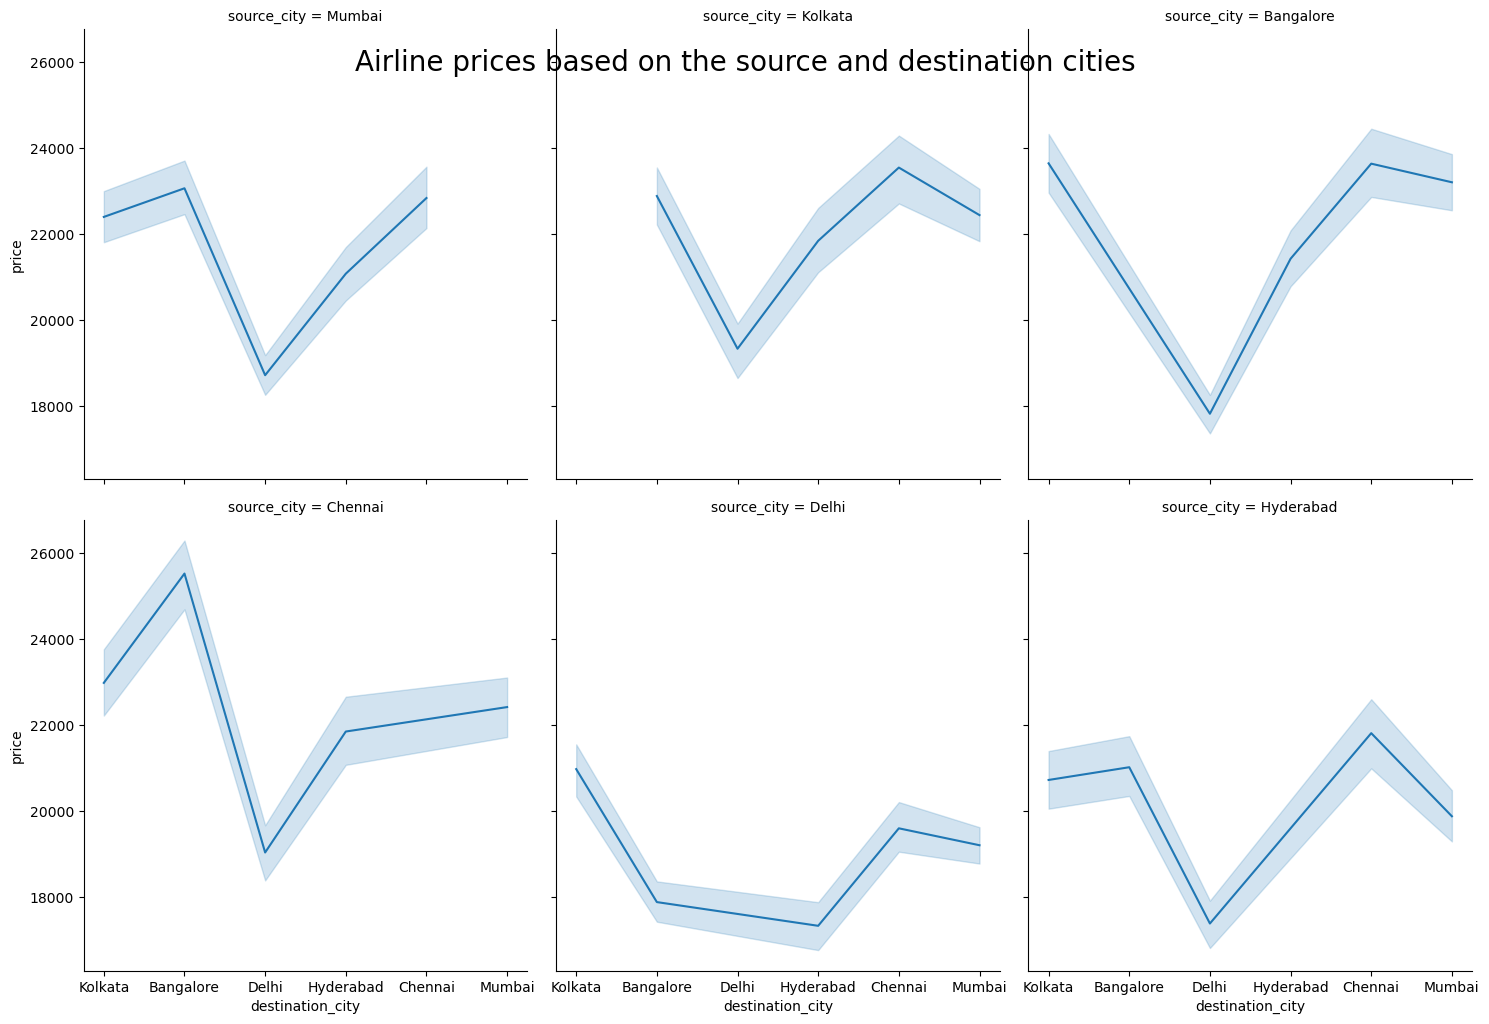

In [22]:
#How the price changes with change in Source city and Destination city?
ax = sns.relplot(col="source_city", y="price", kind="line",x='destination_city', data=sub_df, col_wrap=3)
ax.fig.subplots_adjust(top=1) # adjust the Figure in rp
ax.fig.suptitle('Airline prices based on the source and destination cities',fontsize=20)

In [23]:
#On one hand, it seems that flight leaving from Delhi are often 
# cheaper that from other source cities and the capital is also the 
# cheapest destination to go probably because as a capital cities, 
# the airport is the biggest and proposes more flights. In an other 
# hand, the prices are more or less similar and Hyderabad being the 
# most expensive destination.

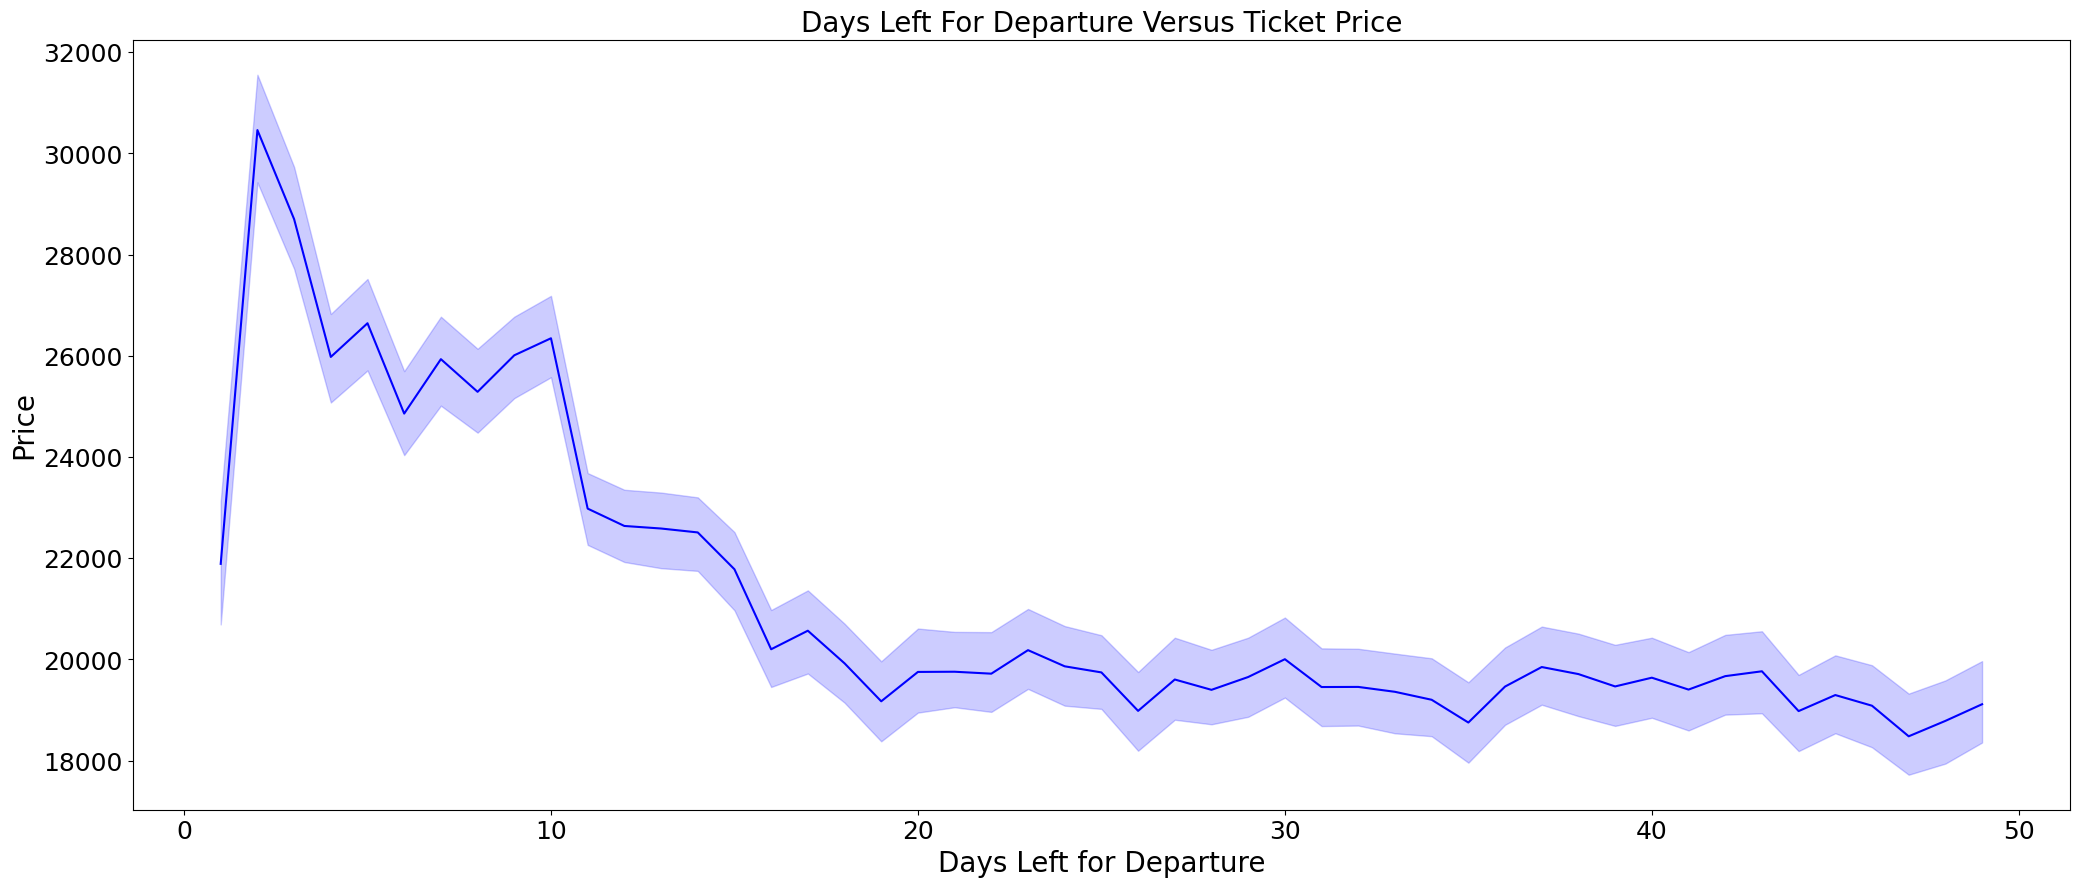

In [24]:
#How does the price affected on the days left for Departure?
plt.figure(figsize=(25,10))
sns.lineplot(data=sub_df,x='days_left',y='price',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

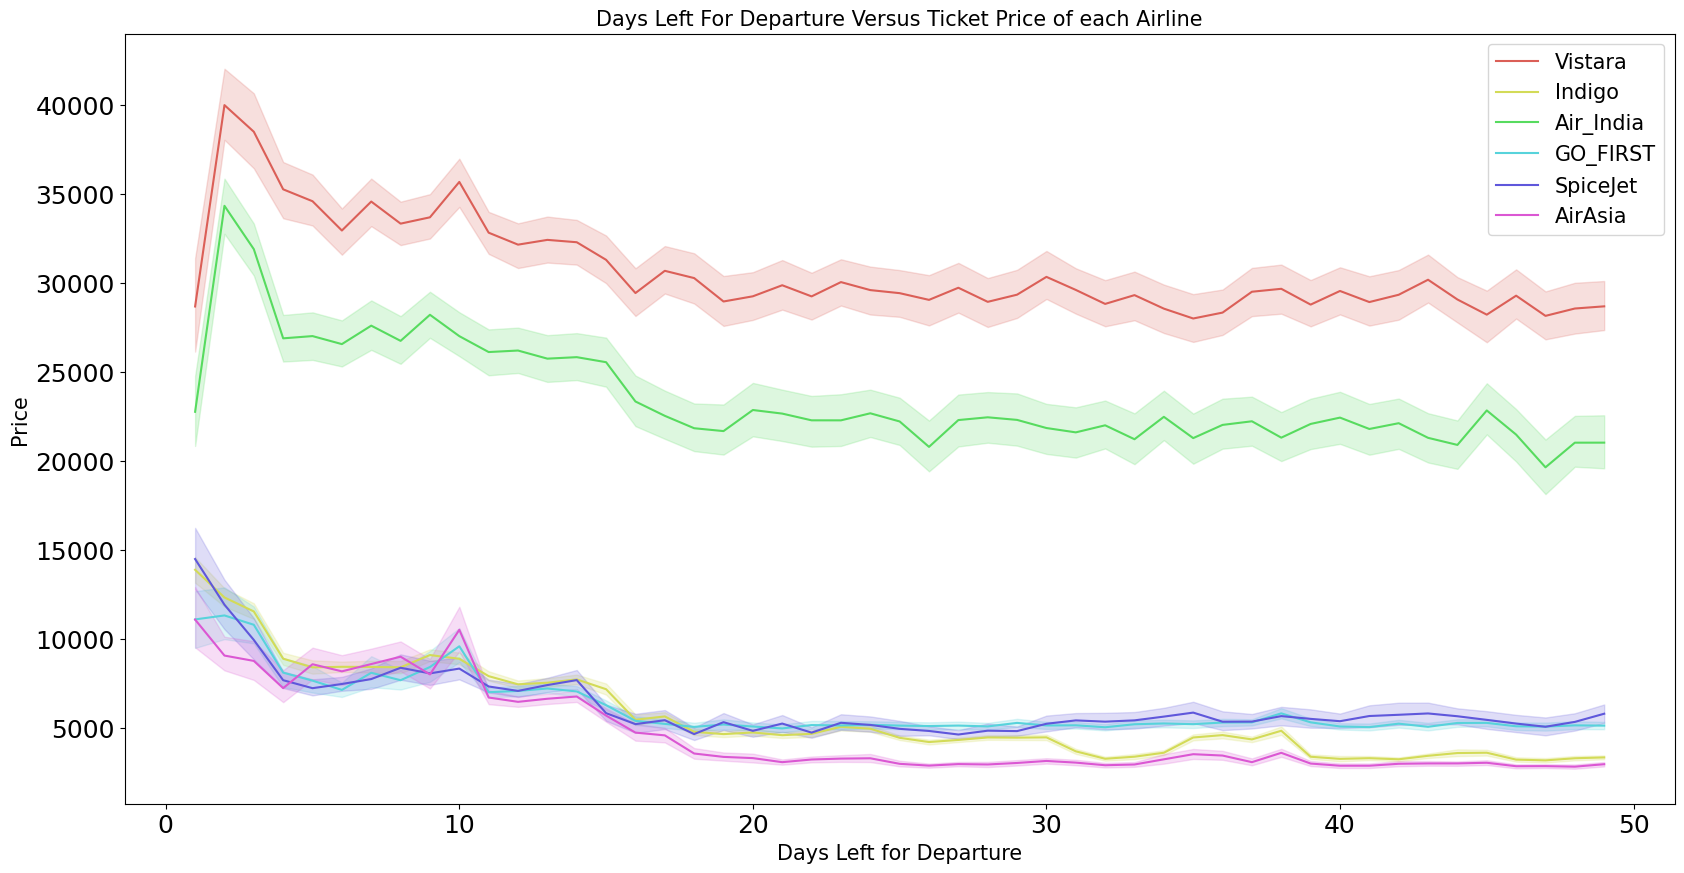

In [25]:
plt.figure(figsize=(20,10))
sns.lineplot(data=sub_df,x='days_left',y='price',color='blue',hue='airline',palette='hls')
plt.title('Days Left For Departure Versus Ticket Price of each Airline',fontsize=15)
plt.legend(fontsize=15)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.tick_params(axis='both', labelsize=18)
plt.show()

In [26]:
#Observation
#As we can see when compared to others when there are two days 
# remaining for departure then the Ticket Price is very High 
# for all the airlines. The prices of Vistara and Air india fall before 1 day.
# From day 20 prices of all airlines are increasing rapidly.  

In [27]:
#Total no. of flights from one city to another
sub_df.groupby(['flight','source_city','destination_city','airline','class'],as_index=False).count().groupby(['source_city','destination_city'],as_index=False)['flight'].count()

,source_city,destination_city,flight
0,Bangalore,Chennai,103
1,Bangalore,Delhi,219
2,Bangalore,Hyderabad,129
3,Bangalore,Kolkata,165
4,Bangalore,Mumbai,172
5,Chennai,Bangalore,68
6,Chennai,Delhi,103
7,Chennai,Hyderabad,80
8,Chennai,Kolkata,108
9,Chennai,Mumbai,94


In [28]:
#Average Price of different Airlnes from Source city to Destination city
df.groupby(['airline','source_city','destination_city'],as_index=False)['price'].mean().head(10)

,airline,source_city,destination_city,price
0,AirAsia,Bangalore,Chennai,2073.043478
1,AirAsia,Bangalore,Delhi,4807.092426
2,AirAsia,Bangalore,Hyderabad,2931.494792
3,AirAsia,Bangalore,Kolkata,4443.468160
4,AirAsia,Bangalore,Mumbai,3342.385350
5,AirAsia,Chennai,Bangalore,1914.760870
6,AirAsia,Chennai,Delhi,3697.314003
7,AirAsia,Chennai,Hyderabad,2053.182540
8,AirAsia,Chennai,Kolkata,3682.338762
9,AirAsia,Chennai,Mumbai,2691.100000


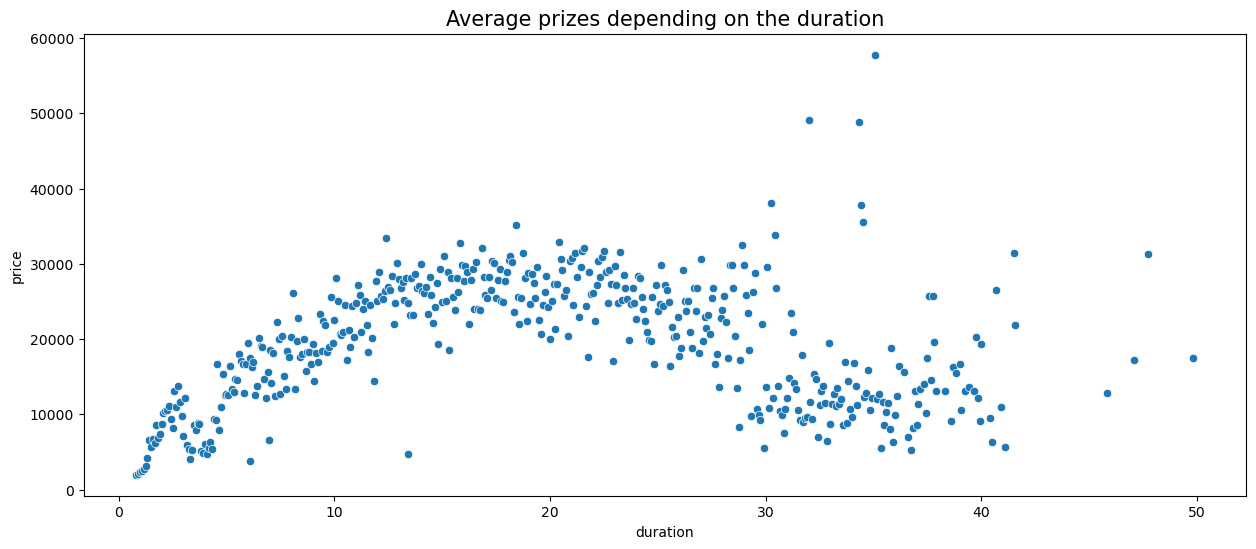

In [29]:
#Does the price change with the duration of the flight?
df_temp = sub_df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

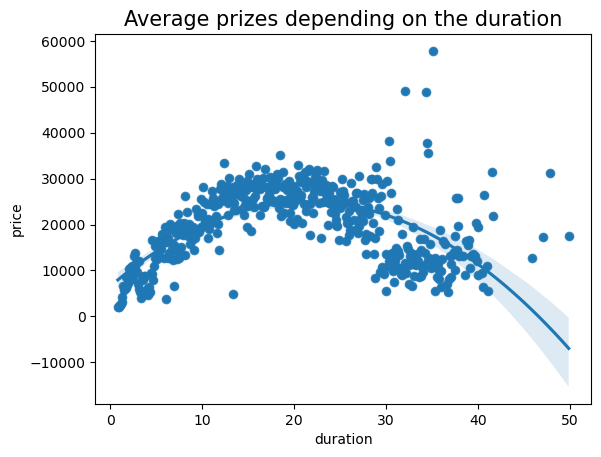

In [30]:
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)
ax = sns.regplot(x="duration", y="price", data=df_temp, order=2)

In [31]:
##Observation
#It is clear that here the relationship is not linear but can be approximated 
# with a second degree curve. The prices reaches a high price at a duration 
# of 20 hours before lowering again. However some outliers seem to affect 
# the regression curve 

In [32]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150076 entries, 70077 to 137172
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           150076 non-null  object 
 1   flight            150076 non-null  object 
 2   source_city       150076 non-null  object 
 3   departure_time    150076 non-null  object 
 4   stops             150076 non-null  object 
 5   arrival_time      150076 non-null  object 
 6   destination_city  150076 non-null  object 
 7   class             150076 non-null  object 
 8   duration          150076 non-null  float64
 9   days_left         150076 non-null  int64  
 10  price             150076 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 17.8+ MB


In [33]:
#It is clear that columns datatype are objects. While most of the Ml algorithms
# only work with numeric values. Since these categorical features cannot be directly 
# used in most machine learning algorithms, the categorical features need to 
# be transformed into numerical features.While numerous techniques exist to 
# transform these features, the most common technique is one-hot encoding.
# In one-hot encoding, a categorical variable is converted into a set of 
# binary indicators (one per category in the entire dataset).

In [34]:
# Converting the labels into a numeric form using Label Encoder
def preprocessing(df):
    #Encode the ordinal variables "stops" and "class".
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)
    
    #Create the dummy variables for the cities, the times and the airlines.
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    
    #Create the dummy variables for the cities, the times and the airlines.
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)
    
    return df

In [35]:
df_preprocessed = preprocessing(sub_df)

In [36]:
df_preprocessed.head()

,stops,class,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,...,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
70077,1,0,23.83,48,5949,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
120035,1,0,9.58,4,31952,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
122734,1,0,16.67,21,7900,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
248354,1,1,13.08,46,42521,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
99269,1,0,9.33,30,11039,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0


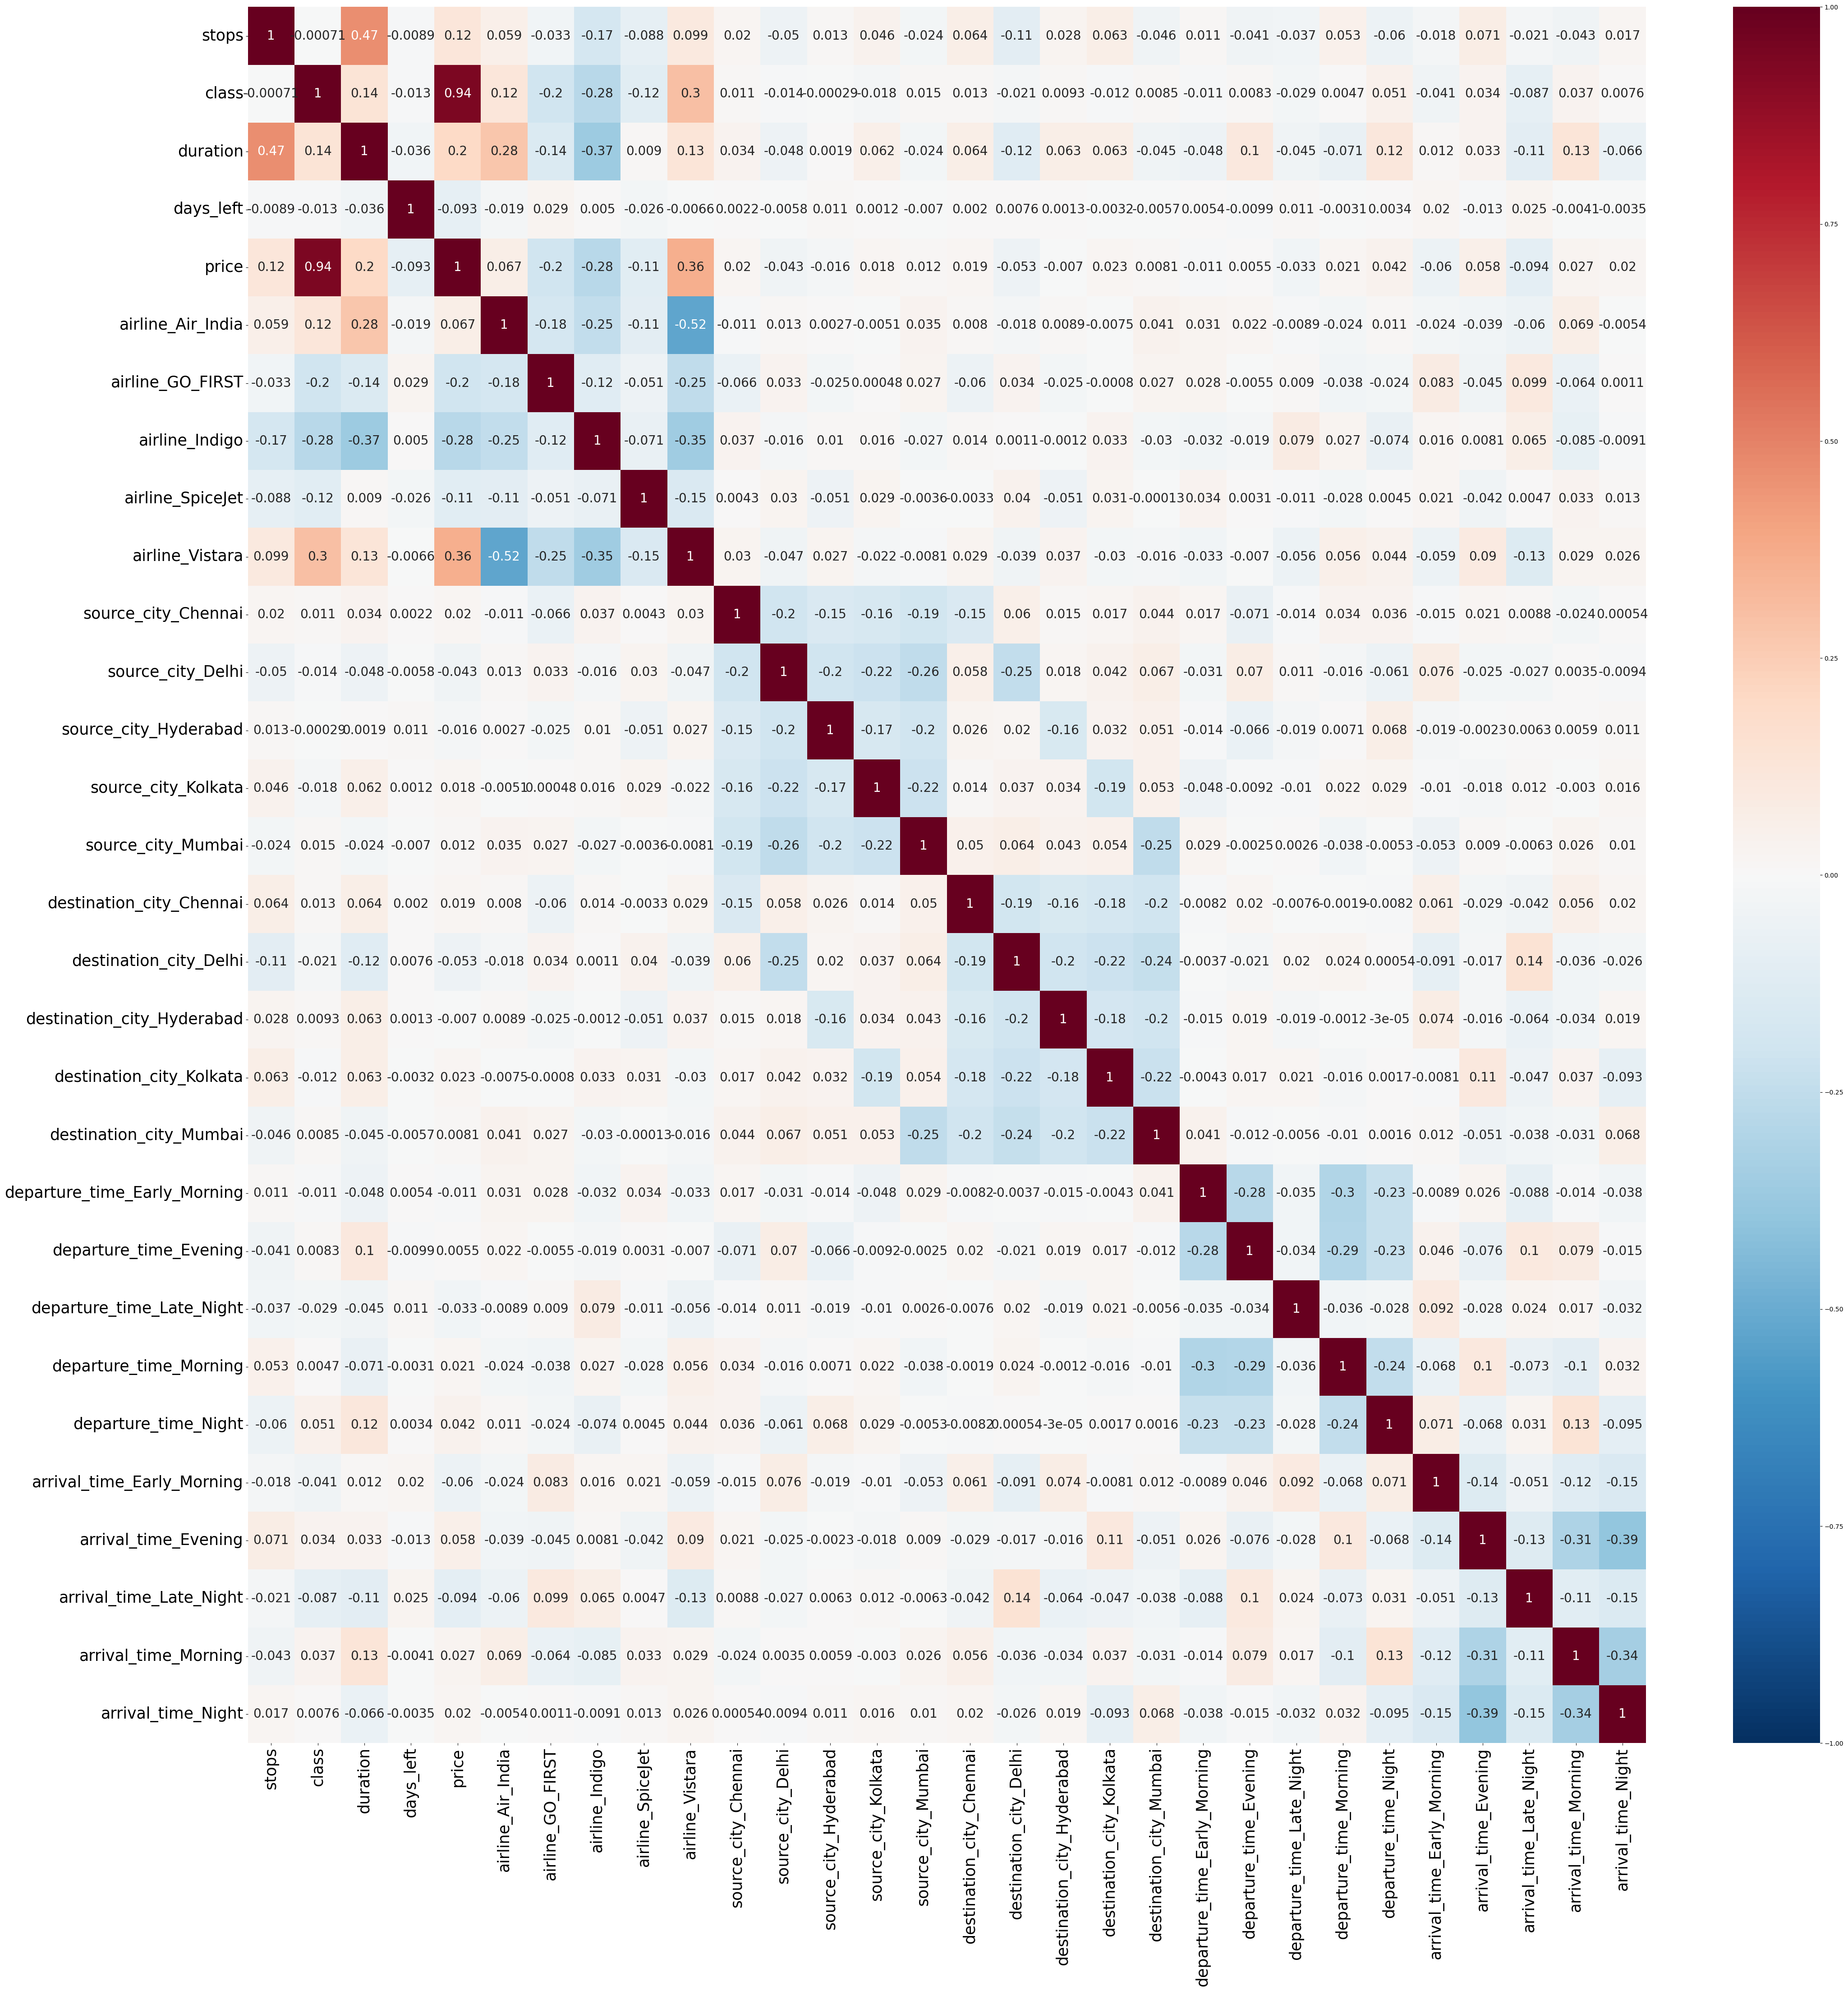

In [37]:
#Checking for the correlation
plt.figure(figsize=(50,50))
res = sns.heatmap(df_preprocessed.corr(),annot = True, annot_kws={'size': 20}, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 25, rotation =90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 25, rotation =360)
plt.show()

In [38]:
#However, the correlation is a good metric for linear relationship, but 
# doesn't highlight non linear ones. For that I will use mutual information.

In [39]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        # _ Ignore a value of specific location/index
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores
#first element of sol series is the pair with the biggest correlation

In [40]:
X = df_preprocessed.copy()
y = X.pop("price")

In [41]:
mi_scores = make_mi_scores(X, y)
print(mi_scores.sort_values(ascending=False))

duration                        2.185985
class                           0.617408
airline_Vistara                 0.504328
days_left                       0.419178
source_city_Delhi               0.418843
source_city_Mumbai              0.418253
airline_Air_India               0.390639
stops                           0.382321
destination_city_Delhi          0.375059
destination_city_Mumbai         0.371091
source_city_Kolkata             0.349514
source_city_Hyderabad           0.335845
destination_city_Kolkata        0.328414
source_city_Chennai             0.315613
destination_city_Hyderabad      0.311138
destination_city_Chennai        0.294250
airline_Indigo                  0.277446
airline_GO_FIRST                0.199641
arrival_time_Evening            0.120113
arrival_time_Night              0.101841
departure_time_Evening          0.097534
arrival_time_Morning            0.094098
departure_time_Morning          0.087987
departure_time_Early_Morning    0.086474
airline_SpiceJet

In [42]:
##Observation
#This importance analysis shows us the class or the fast that the flight 
# is a Vistara one but vairables like the duration of the flight or the 
# number of days left have strong non linear relationship too as we saw 
# on the previous questions.

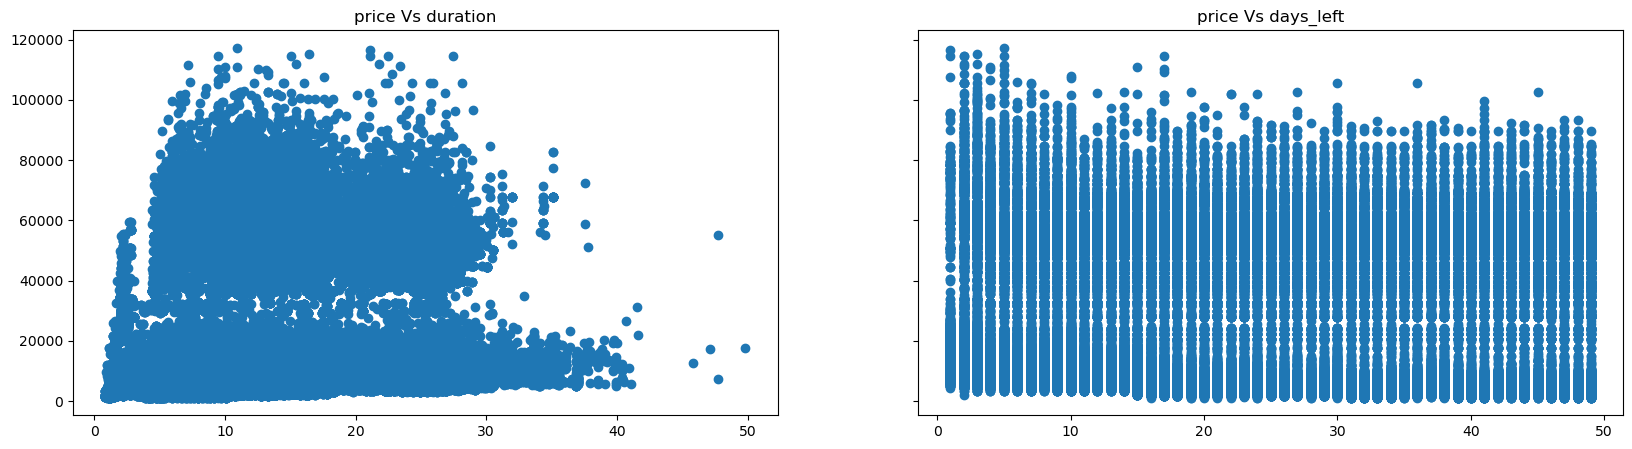

In [43]:
m, (f1, f2) = plt.subplots(1, 2, sharey=True, figsize = (20,5) ) #ploting price with year, days_left, mileage
f1.scatter(df_preprocessed['duration'], df_preprocessed['price'])
f1.set_title('price Vs duration')
f2.scatter(df_preprocessed['days_left'], df_preprocessed['price'])
f2.set_title('price Vs days_left')
plt.show()

In [44]:
#Checking for the multicolinearity, as per the linear regression assumptions theres 
#should be no colinearity among the independent variables(x1, x2, x3..)
from statsmodels.stats.outliers_influence import variance_inflation_factor #importing the library to calculate VIF
variables = X #defining the features to check
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns

In [45]:
vif

,VIF,features
0,8.068129,stops
1,1.835159,class
2,6.813399,duration
3,4.364189,days_left
4,5.419089,airline_Air_India
5,1.970831,airline_GO_FIRST
6,2.713339,airline_Indigo
7,1.427045,airline_SpiceJet
8,7.776484,airline_Vistara
9,1.730793,source_city_Chennai


In [46]:
#As no VIF is greater than 10, which means all variables are independent to each other.

In [47]:
logger.info("Start Model Building")
##Prediction of the flight prices
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =1, shuffle = True)

INFO Start Model Building


In [48]:
#Although normalization via min-max scaling is a commonly used technique that 
# is useful when we need values in a bounded interval, standardization can be 
# more practical for many machine learning algorithms. The reason is that many 
# linear models, such as the logistic regression and SVM, [...] initialize 
# the weights to 0 or small random values close to 0. Using standardization, 
# we center the feature columns at mean 0 with standard deviation 1 so that 
# the feature columns take the form of a normal distribution, which makes it 
# easier to learn the weights. Furthermore, standardization maintains useful 
# information about outliers and makes the algorithm less sensitive to them 
# in contrast to min-max scaling, which scales the data to a limited range 
# of values.

In [49]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.fit_transform(x_test)
x_train_scaled=pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_scaled=pd.DataFrame(x_test_scaled, columns = x_test.columns)

In [50]:
x_train_scaled.head()

,stops,class,duration,days_left,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,...,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
0,0.185117,-0.672624,-0.136637,1.106353,-0.609611,3.445220,-0.408314,-0.173549,-0.862250,-0.385045,...,1.872883,-0.526428,-0.064962,-0.556165,-0.43502,-0.231982,1.684753,-0.219172,-0.514310,-0.662542
1,0.185117,-0.672624,-1.038856,-0.295428,1.640389,-0.290257,-0.408314,-0.173549,-0.862250,-0.385045,...,-0.533936,1.899594,-0.064962,-0.556165,-0.43502,-0.231982,-0.593559,-0.219172,-0.514310,1.509339
2,0.185117,-0.672624,0.707284,-1.770985,1.640389,-0.290257,-0.408314,-0.173549,-0.862250,-0.385045,...,-0.533936,-0.526428,-0.064962,-0.556165,-0.43502,-0.231982,-0.593559,-0.219172,1.944352,-0.662542
3,0.185117,-0.672624,0.394978,0.516129,1.640389,-0.290257,-0.408314,-0.173549,-0.862250,-0.385045,...,1.872883,-0.526428,-0.064962,-0.556165,-0.43502,-0.231982,-0.593559,-0.219172,-0.514310,1.509339
4,0.185117,-0.672624,-0.379542,1.180130,-0.609611,-0.290257,-0.408314,-0.173549,1.159757,-0.385045,...,1.872883,-0.526428,-0.064962,-0.556165,-0.43502,-0.231982,1.684753,-0.219172,-0.514310,-0.662542


In [51]:
lr_start = time.time()
logger.info("Start of Linear Regression Model")
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
y_pred = lr.predict(x_test_scaled)

#Checking for the overfitting and the underfitting issues
logger.info("Training Accuracy {} ".format(r2_score(y_train,lr.predict(x_train_scaled))*100))
logger.info("Validation Accuracy {}".format(r2_score(y_test,lr.predict(x_test_scaled))*100))



#High training accuracy, low test accuracy = Overfitting(high variances, low bias)
#Low training accuracy, high test accuracy = Underfitting(high bias, low variances)
#Bias: A difference occurs between prediction values made by the model and actual 
# values/expected values, and this difference is known as bias errors or 
# Errors due to bias.
#Variances: variance tells that how much a random variable is different from 
# its expected value.

INFO Start of Linear Regression Model
INFO Training Accuracy 90.98871928824185 
INFO Validation Accuracy 91.06420411389786


In [52]:
mae = mean_absolute_error(y_test, y_pred)
print('MAE score:', mae)
logger.info('MAE of LR Model {}'.format(mae))

#MAE is a very simple metric which calculates the absolute difference between 
# actual and predicted values. The MAE of your model which is basically a 
# mistake made by the model known as an error. So, sum all the errors and 
# divide them by a total number of observations And this is MAE. And we aim 
# to get a minimum MAE because this is a loss.

r2 = r2_score(y_test, y_pred)
print('R2 score:', r2)
logger.info('R2 Score score of LR Model {}'.format(r2))

#The disadvantage of the R2 score is while adding new features in data the 
# R2 score starts increasing or remains constant but it never decreases 
# because It assumes that while adding more data variance of data increases.
#r2 = 1-(sum of squared error of regression line/squared sum error of mean line)

#rmse = mean_squared_error(y_test, y_pred, squared=False)
#Setting squared to False will return the RMSE.
#print('RMSE score:', rmse)

# adjusted R-squared
adj_r2 = 1 - (1-r2_score(y_test, y_pred)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print('adjusted_R-squared:', adj_r2)
logger.info("Adjusted R2 score of LR Model {}".format(adj_r2))

#The disadvantage of the R2 score is while adding new features in data the R2 
# score starts increasing or remains constant but it never decreases because 
# It assumes that while adding more data variance of data increases.
#But the problem is when we add an irrelevant feature in the dataset then at 
# that time R2 sometimes starts increasing which is incorrect.

lr_end = time.time()
print('Linear Regression time: ', (lr_end - lr_start))

INFO MAE of LR Model 4533.475940391814
INFO R2 Score score of LR Model 0.9106420411389786
INFO Adjusted R2 score of LR Model 0.9106247705632421


MAE score: 4533.475940391814
R2 score: 0.9106420411389786
adjusted_R-squared: 0.9106247705632421
Linear Regression time:  0.2882251739501953


In [53]:
residuals = y_test.values-y_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals:", mean_residuals)
logger.info('Mean Residuals of LR Model {}'.format(mean_residuals))
#Residuals as we know are the differences between the true value and the 
# predicted value. One of the assumptions of linear regression is that the 
# mean of the residuals should be zero

INFO Mean Residuals of LR Model 107.14135060457957


Mean of Residuals: 107.14135060457957


INFO Linear Regression Model is done.


BartlettResult(statistic=41963.583253260666, pvalue=0.0)


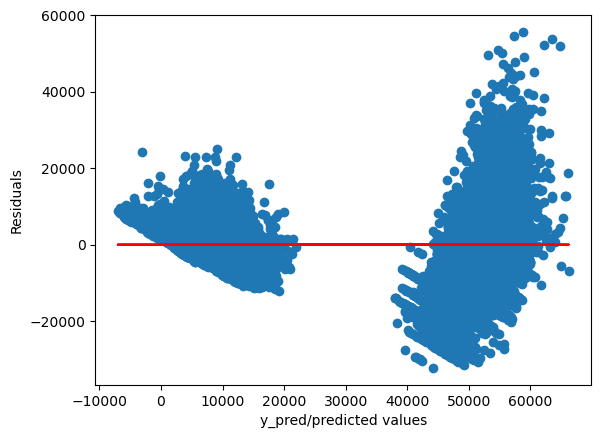

In [54]:
#Check for Homoscedasticity
#Homoscedasticity means that the residuals have equal or almost equal 
# variance across the regression line. By plotting the error terms with 
# predicted terms we can check that there should not be any pattern in the 
# error terms.
plt.scatter(y_pred, residuals)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.plot(y_pred, [0]*len(y_pred), color='red')
hmsc_test = bartlett( y_pred,residuals)
print(hmsc_test)

logger.info("Linear Regression Model is done.")

In [55]:
#It is clear that error is not constant across the values of the dependent variables.

#checking with another alogrithm

logger.info("Start of Random Forest Regression")

rfr_start = time.time()
rfr = RandomForestRegressor()
rfr.fit(x_train_scaled, y_train)
y_pred_rfr = rfr.predict(x_test_scaled)

#Checking for the overfitting and the underfitting issues
logger.info('Training Accuracy {} '.format(r2_score(y_train,rfr.predict(x_train_scaled))*100))
logger.info('Validation Accuracy {} '.format(r2_score(y_test,rfr.predict(x_test_scaled))*100))

INFO Start of Random Forest Regression
INFO Training Accuracy 99.751483317738 
INFO Validation Accuracy 98.30619674627143 


In [56]:
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
print('MAE score:', mae_rfr)
logger.info('MAE of RFR Model{}'.format(mae_rfr))

r2_rfr = r2_score(y_test, y_pred_rfr)
print('R2 score:', r2_rfr)
logger.info('R2 score of RFR Model {}'.format(r2_rfr))

adj_r2_rfr = 1 - (1-r2_score(y_test, y_pred_rfr)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print('adjusted_R-squared:', adj_r2)
logger.info('Adjusted R2 score of RFR Model {}'.format(adj_r2_rfr))

rfr_end = time.time()
print('Random Forest Regressot time:', (rfr_end - rfr_start))

logger.info("End of the Random Forest Regression Model")

INFO MAE of RFR Model1265.0288950265199
INFO R2 score of RFR Model 0.9830619674627142
INFO Adjusted R2 score of RFR Model 0.9830586937803529
INFO End of the Random Forest Regression Model


MAE score: 1265.0288950265199
R2 score: 0.9830619674627142
adjusted_R-squared: 0.9106247705632421
Random Forest Regressot time: 41.280282497406006


In [57]:
logger.info("Start of Stacking Model")
#Checking with stacking
stack_start = time.time()

estimators = [('lr', LinearRegression()), ('etr', ExtraTreesRegressor())]

stack_reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10,random_state=1))

stack_reg.fit(x_train_scaled, y_train)

INFO Start of Stacking Model


StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('etr', ExtraTreesRegressor())],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=1))

In [58]:
y_pred_stack = stack_reg.predict(x_test_scaled)
#Checking for the overfitting and the underfitting issues
logger.info('Training Accuracy {} '.format(r2_score(y_train,stack_reg.predict(x_train_scaled))*100))
logger.info('Validation Accuracy {} '.format(r2_score(y_test,stack_reg.predict(x_test_scaled))*100))

INFO Training Accuracy 99.3423107557005 
INFO Validation Accuracy 97.69965098762775 


In [59]:
mae_stack = mean_absolute_error(y_test, y_pred_stack)
print('MAE score:', mae_stack)
logger.info('MAE of Stacking Model {}'.format(mae_stack))

r2_stack = r2_score(y_test, y_pred_stack)
print('R2 score:', r2_stack)
logger.info('R2 score of Stacking Model {}'.format(r2_stack))

adj_r2_stack = 1 - (1-r2_score(y_test, y_pred_stack)) * (len(y)-1)/(len(y)-X.shape[1]-1)
print('adjusted_R-squared:', adj_r2_stack)
logger.info('Adjusted R2 score of Stacking Model {}'.format(adj_r2_stack))

stack_end = time.time()
print('Stacking Model time:', (stack_end - stack_start))

INFO MAE of Stacking Model 1727.8021569960108
INFO R2 score of Stacking Model 0.9769965098762775
INFO Adjusted R2 score of Stacking Model 0.9769920638982869


MAE score: 1727.8021569960108
R2 score: 0.9769965098762775
adjusted_R-squared: 0.9769920638982869
Stacking Model time: 194.56983065605164


In [60]:
## Take away points:
#1. The model that gives the best result is the Random Forest Regressor with
# on the test dataset an R^2 score equals to 0.9808 and a MSE score equals 
# to 1398.37.

#2. There is a big gap between flight tickets in business and economy. In 
# average business tickets are 6.5 times more expensive than economy tickets.

#3. Vistara and AirIndia seems to be the most expensive companies and 
# AirAsia the cheapest. However for business tickets, only Vistara and 
# AirIndia are available, and Vistara is slightly more expensive.

#4. In general, prices rise quite slowly until 20 days before the flight 
# where the prices rise drastically. But one day before the flight, 
# there usually are empty seats that have not been sold. Thus it is possible 
# to find tickets three times cheaper than the day before.

#5. The longer the flight is the more expensive the tickets are until it 
# reaches around 20 hours, then the prices tend to decrease.

#6. For the time of the flight:
# It seems that departure during the afternoon and late night are cheaper, 
# and night more expensive.
#It seems that departure during the early morning, afternoon and late night 
# are cheaper, and evening more expensive.

# 7. For the cities of the trip:
# Flights from Delhi are the cheapest the from the others cities seems equal 
# on average but slightly more expensive for Chenai.
# Flight to Delhi are the cheapest and to Bengalore the most expensive ones.

# 8. In general, the more stops there are, the more expensive the 
# flight ticket is.

end = time.time()
print('Total Time: ', (end - start))

#saving the model to resue.
file = open('Flight_Price_Predictions.pkl', 'wb')
pickle.dump(rfr, file)

Total Time:  363.0296003818512
